#### Module Summary
> This module fits the stepwise logistic regression and helps the user to build the final logistic regression to the data
>
> **Input Files**
> 1. Development and Validation WOE/ Dummy vars Data (pickle)
> 2. Feature Reduction Summary (excel)
> 3. Scoring pickle file - model metadata (pickle)
>
> **Output Files**
> 1. Model Results (excel)
> 2. Scoring pickle file - Model Metadata (pickle)

<h4> 4.1 Import Libraries & Parameters and Initialise Output

In [1]:
# Import Libraries and Parameters
import logit_config as cfg
exec(open('module_imports.py').read())

In [2]:
model_approach = 'woe'             # Options are - i. woe ii. dummy_vars
logit_method = 'logistic'          # Options are - i. logistic ii. l1

<h4> 4.2 Prepare Data for Model Input

In [3]:
# Import Data
with open(f"{outpath}/model_data.pickle", 'rb') as f:
    model_data_pckl_dict = pickle.load(f)
dev_data = copy.deepcopy(model_data_pckl_dict[f'dev_data_{model_approach}'])
val_data = copy.deepcopy(model_data_pckl_dict[f'val_data_{model_approach}'])

# Check for Degenerate Columns in Validation Data
val_degen_cols = [col for col in val_data.columns if val_data[col].nunique()==1]
if len(val_degen_cols) > 0:
    print(f'Degenerate Columns in Validation Data: {val_degen_cols}')

In [4]:
# Drop Problematic Variables
drop_col_pattern_list = []
drop_col_list = [x for x in dev_data.columns if any(y in x for y in drop_col_pattern_list)] + val_degen_cols
dev_data.drop(drop_col_list, axis=1, inplace=True)

print(f'Development Data Shape: {dev_data.shape}\nDevelopment Response Rate: {np.round(dev_data[resp_var].sum()/dev_data.index.size*100, 4)}%')

# Prepare Training and Test Data Array
X_train_orig = sm.add_constant(dev_data.drop(id_varlist+[resp_var], axis=1))
y_train = dev_data[resp_var]

keep_col_list = [x for x in X_train_orig.columns.tolist() if x!= 'const']
X_test = sm.add_constant(val_data[keep_col_list], has_constant='raise')
y_test = val_data[resp_var]

Development Data Shape: (341, 20)
Development Response Rate: 36.6569%


<h4> 4.3 Stepwise Logistic Regression

In [5]:
%%time

# Run Stepwise Regression to get Final Variable List
stepwise_df, stepwise_varlist = stepwise_selection(X_train_orig, y_train)

print(f'# Resulting Features: {len(stepwise_varlist)}\n\nResulting features: {stepwise_varlist}')

Add Intercept                      with p-value 1.3820675154460912e-35
Add  L_concavity_worst              with p-value 1.82117e-46
Add  L_radius_se                    with p-value 4.90741e-18
Add  L_texture_worst                with p-value 8.26192e-10
Add  L_compactness_mean             with p-value 1.45102e-05
Add  L_smoothness_se                with p-value 5.76615e-05
Add  L_concave points_worst         with p-value 0.000218409
Add  L_symmetry_se                  with p-value 0.000649924
Add  L_symmetry_worst               with p-value 0.000144837
Add  L_texture_se                   with p-value 0.00144454
Add  L_fractal_dimension_mean       with p-value 0.00649508
Add  L_smoothness_worst             with p-value 0.00302943
Add  L_concave points_se            with p-value 0.0137005
# Resulting Features: 13

Resulting features: ['const', 'L_concavity_worst', 'L_radius_se', 'L_texture_worst', 'L_compactness_mean', 'L_smoothness_se', 'L_concave points_worst', 'L_symmetry_se', 'L_symm

In [6]:
# Stepwise Data
stepwise_df.reset_index(drop=True, inplace=True)
stepwise_df['step_num'] = stepwise_df.index + 1

# Export Stepwise Data
export_data_to_excel(stepwise_df[['step_num', 'step', 'feature', 'p-val']], f'{outpath}/{feature_reduction_outfile}', sheetName='Stepwise Logistic')

stepwise_dropover_df = pd.DataFrame([x for x in dev_data.columns.tolist() if x not in non_pred_varlist+stepwise_varlist], columns=['feature'])
stepwise_dropover_df['drop_reason'] = 'stepwise_logistic'

drop_reason_df = pd.read_excel(f'{outpath}/{feature_reduction_outfile}', sheet_name='Drop Reason Summary')
drop_reason_df = drop_reason_df.append(stepwise_dropover_df)
export_data_to_excel(drop_reason_df, f'{outpath}/{feature_reduction_outfile}', sheetName='Drop Reason Summary')

<h4> 4.4 Model Fit - First Iteration

In [7]:
# Select Features from Stepwise
X_train_stepwise = X_train_orig[stepwise_varlist]
X_test_stepwise = X_test[stepwise_varlist]

# Initial Run
model_results_df, logit_model_obj = run_logistic(X_train_stepwise, y_train, logit_method, resp_var)

Optimization terminated successfully.
         Current function value: 0.138737
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  341
Model:                          Logit   Df Residuals:                      328
Method:                           MLE   Df Model:                           12
Date:                Tue, 10 May 2022   Pseudo R-squ.:                  0.7889
Time:                        18:33:19   Log-Likelihood:                -47.309
converged:                       True   LL-Null:                       -224.07
Covariance Type:            nonrobust   LLR p-value:                 2.528e-68
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9190      0.340     -2.706      0.007      -1.585

In [8]:
vif_df = check_vif(X_train_stepwise)
vif_df.head()

,feature,VIF
1,L_concavity_worst,2.02
4,L_compactness_mean,1.90
0,const,1.65
12,L_concave points_se,1.62
2,L_radius_se,1.41


<h4> 4.5 Subsequent Runs - needs manual intervention

In [9]:
# Initialise Master Drop Variable List  - Run this only once
master_drop_varlist = []

In [10]:
# List of Variables with high p-value or VIF
drop_var_list = model_results_df[(model_results_df['pval'] > 0.05) | (model_results_df['pval'].isnull())]['feature'].tolist()
# drop_var_list = vif_df[vif_df['VIF'] > 3]['feature'].tolist()
drop_var_list = [x for x in drop_var_list if x != 'const']

# Manual Input
# drop_var_list = []

# Update Final Variable List
master_drop_varlist = master_drop_varlist + drop_var_list
keep_varlist = []

master_drop_varlist = [x for x in drop_var_list if x not in keep_varlist]
new_train_varlist = [x for x in stepwise_varlist if x not in master_drop_varlist]
print(f'# Variables in New Training List: {len(new_train_varlist)}')

# Variables in New Training List: 10


In [11]:
# Model Iteration
model_results_df, logit_model_obj = run_logistic(X_train_stepwise[new_train_varlist], y_train, logit_method, resp_var)
vif_df = check_vif(X_train_stepwise[new_train_varlist])

Optimization terminated successfully.
         Current function value: 0.154761
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  341
Model:                          Logit   Df Residuals:                      331
Method:                           MLE   Df Model:                            9
Date:                Tue, 10 May 2022   Pseudo R-squ.:                  0.7645
Time:                        18:33:22   Log-Likelihood:                -52.773
converged:                       True   LL-Null:                       -224.07
Covariance Type:            nonrobust   LLR p-value:                 2.329e-68
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.0806      0.337     -3.204      0.001      -1.741

In [12]:
# Display VIF
vif_df.head()

,feature,VIF
0,const,1.60
1,L_concavity_worst,1.51
2,L_radius_se,1.26
5,L_concave points_worst,1.25
3,L_texture_worst,1.18


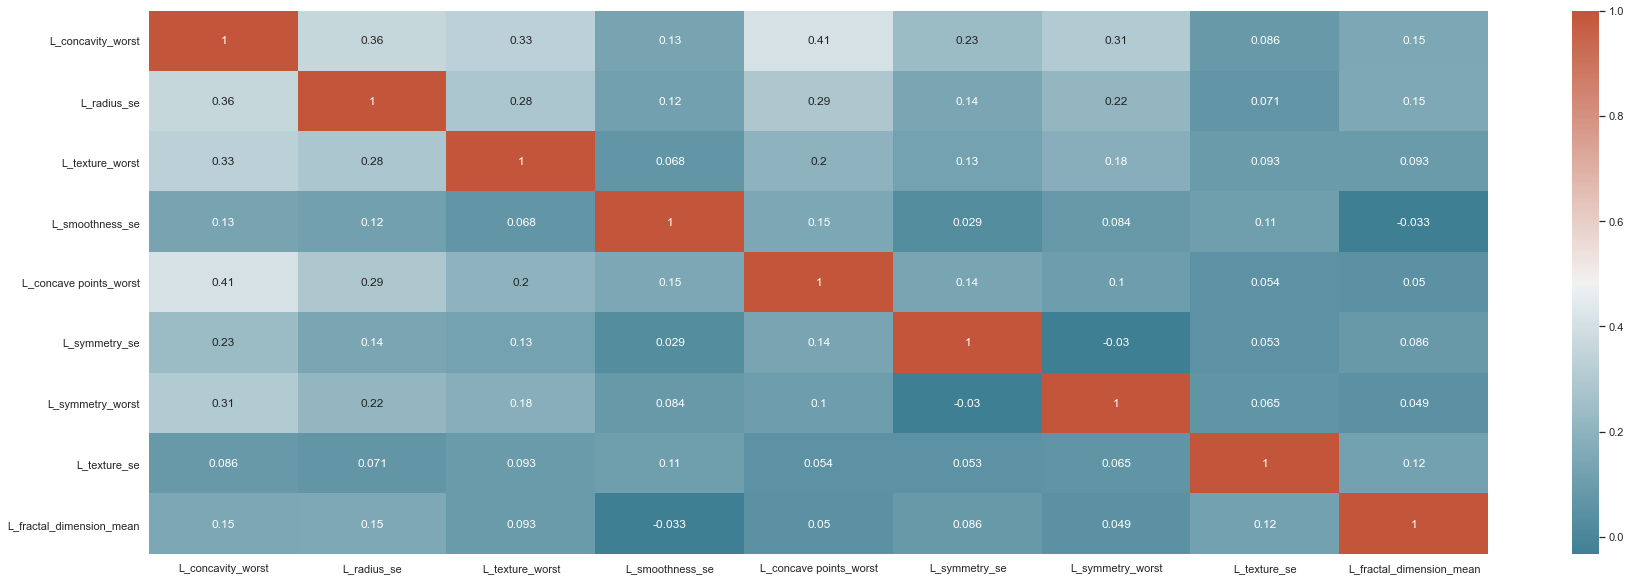

In [13]:
%matplotlib inline

# Draw Correlation Plot
corr = X_train_stepwise[new_train_varlist].drop('const', axis=1).corr()
sns.set(rc={'figure.figsize': (30, 10)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.savefig(f'{outpath}/correlation_plot.png')

<h4> 4.6 Performance Parameters

In [14]:
# Update Final Varlist
if not 'new_train_varlist' in globals():
    logit_varlist = stepwise_varlist
else:
    logit_varlist = new_train_varlist

In [15]:
# Create Leaderboard
leaderboard_df = create_leaderboard(X_train_stepwise[logit_varlist], y_train, X_test[logit_varlist], y_test, resp_var, logit_model_obj)
leaderboard_df.head(20)

,Metrics,Values
0,Gini_S1,0.970815
1,Gini_S2,0.827179
2,GiniVariance,14.800000
3,KS_S1,0.882556
4,KS_S2,0.674493
5,PSI,0.103551
6,S1_TN,201.000000
7,S1_FP,15.000000
8,S1_FN,7.000000
9,S1_TP,118.000000


In [16]:
# Rank Ordering
rank_order_df = get_rank_order_data(logit_model_obj, X_train_stepwise[logit_varlist], y_train)
rank_order_df

,decile,obs_cnt,resp_cnt,resp_pct,cum_resp_pct
0,1,35,35,0.280,0.280
1,2,34,34,0.272,0.552
2,3,34,30,0.240,0.792
3,4,34,20,0.160,0.952
4,5,34,6,0.048,1.000
5,6,34,0,0.000,1.000
6,7,34,0,0.000,1.000
7,8,34,0,0.000,1.000
8,9,34,0,0.000,1.000
9,10,34,0,0.000,1.000


In [17]:
# Calculate Concordance
get_concordance(logit_model_obj, X_train_stepwise[logit_varlist], y_train)

{'pct_concordance': 98.54,
 'pct_discordance': 1.46,
 'pct_ties': 0.0,
 'pairs_tested': 27000}

<h4> 4.7 Model Data Export

<font color=blue>Make sure that the logit_model_obj object has the final version of the logistic/ l1 model before saving it to the model metadata pickle file</font>

In [20]:
# Import and Update Pickle Dictionary Object
with open(f"{outpath}/model_metadata.pickle", 'rb') as f:
    model_metadata_pckl_dict = pickle.load(f)
model_metadata_pckl_dict['model'] = logit_model_obj
model_metadata_pckl_dict['model_approach'] = model_approach
model_metadata_pckl_dict['logit_method'] = logit_method

# Export Updated Dictionary Object back into Pickle
with open(f"{outpath}/model_metadata.pickle", 'wb') as f:
    pickle.dump(model_metadata_pckl_dict, f)